# Initialize   

In [1]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ModuleNotFoundError: No module named 'numpy'

# SEIR Class

In [2]:
class SEIRModel:
    def __init__(self, population, beta, sigma, gamma):
        self.population = population
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.s = 100 
        self.e = 10
        self.i = 0
        self.r = 0

    def step(self):
        new_infections = self.beta * self.s * self.i / self.population
        new_exposed = new_infections
        new_recovered = self.gamma * self.i
        self.s -= new_infections
        self.e += new_exposed
        self.i += new_infections - new_recovered
        self.r += new_recovered

    def get_infected(self):
        return int(self.i)

    def __call__(self, y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

# Load data

In [3]:
def load_df(data_name: str) -> pd.DataFrame:
  path = f"nb_datasets/{data_name}"

  df:pd.DataFrame = pd.read_csv(path)

  # ensure sort by date
  df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d/%m/%Y')
  df_sorted: pd.DataFrame = df.sort_values(by='date')
  
  return df_sorted

# Split data

In [4]:
def load_observed(df: pd.DataFrame, brgy_name: str) -> pd.DataFrame:
  
  df_sorted: pd.DataFrame = df[df['barangay_Res'] == brgy_name]

  # keep relevant cols
  keep_cols = ["date", "count_Exposed", "count_Infectious", "count_Recovered"]
  main_df: pd.DataFrame = df_sorted[df_sorted.columns.intersection(keep_cols)]

  # Observed data (e.g., daily infections)
  # observed_data = main_df['count_Infectious'].to_numpy()

  # total_cases = main_df['count_Infectious'].sum()
  
  return main_df


# Sim Anneal Code

In [71]:
# Simulate SEIR model
def simulate_seir(beta, sigma, gamma, y0, t, n):
    N = n
    seir_model = SEIRModel(N, beta, sigma, gamma)
    
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    
    return S, E, I, R
      

# # Objective function
# def objective_function(params, observed_data, initial_conditions, time_points, n):
#     beta, sigma, gamma = params

#     # Simulate the SEIR model with given parameters
#     s, predicted_E, predicted_I, predicted_R = simulate_seir(beta, sigma, gamma, initial_conditions, time_points, n)
    
#     # Split observed data into compartments
#     observed_E, observed_I, observed_R = observed_data[:, 0], observed_data[:, 1], observed_data[:, 2]
    
#     # Calculate metrics for each compartment
#     metrics = {}
#     mae_dict = {}
#     rmse_dict = {}
    
#     for compartment, observed, predicted in zip(
#         ["E", "I", "R"],
#         [observed_E, observed_I, observed_R],
#         [predicted_E, predicted_I, predicted_R]
#         ):
    
#         mae = mean_absolute_error(observed, predicted)
#         rmse = np.sqrt(mean_squared_error(observed, predicted))

#         # Normalize metrics
#         mae_normalized = mae / np.max(observed)  # Scale by max value
#         rmse_normalized = rmse / np.max(observed)  # Scale by max value

#         # Weighted average for each compartment
#         combined_metric = (0.5 * mae_normalized) + (0.5 * rmse_normalized)
#         metrics[compartment] = combined_metric
#         mae_dict[compartment] = mae
#         rmse_dict[compartment] = rmse

#     # Combine all compartments (average or weighted sum)
#     total_metric = np.mean(list(metrics.values()))  # Equal weight to all compartments
#     # for logging
#     total_mae = np.mean(list(mae_dict.values()))
#     total_rmse = np.mean(list(rmse_dict.values()))
    
#     return total_metric, total_mae, total_rmse


# Objective function
def objective_function(params, observed_data, initial_conditions, time_points, n):
    beta, sigma, gamma = params

    # Simulate the SEIR model with given parameters
    s, predicted_E, predicted_I, predicted_R = simulate_seir(beta, sigma, gamma, initial_conditions, time_points, n)
    
    # Split observed data into compartments (only I for Infectious)
    observed_I = observed_data[:, 1]  # Only infectious data
    predicted_I = predicted_I  # Predicted infectious data
    
    # Calculate metrics for Infectious compartment
    mae = mean_absolute_error(observed_I, predicted_I)
    rmse = np.sqrt(mean_squared_error(observed_I, predicted_I))

    # Normalize metrics
    mae_normalized = mae / np.max(observed_I)  # Scale by max value
    rmse_normalized = rmse / np.max(observed_I)  # Scale by max value

    # Weighted average for Infectious compartment
    combined_metric = (0.5 * mae_normalized) + (0.5 * rmse_normalized)

    # Combine metrics (since only Infectious is considered)
    total_metric = combined_metric
    # For logging purposes
    total_mae = mae
    total_rmse = rmse
    
    return total_mae, total_mae, total_rmse


# Simulated Annealing for SEIR parameter tuning
def simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter, n):
    # Initial parameter guesses
    current_params = [0.5, 0.5, 0.5]  # Initial guesses for beta, sigma, gamma
    current_cost, current_mae, current_rmse = objective_function(current_params, observed_data, initial_conditions, time_points, n)
    best_params = current_params
    best_mae, best_rmse = current_mae, current_rmse
    best_cost = current_cost

    cost_list = []
    
    min_temp = 1e-5 
    initial_temp = temp
    
    for i in range(max_iter):
        # Generate new candidate parameters
        new_params = [param + random.uniform(-0.15, 0.15) for param in current_params]
        new_params = np.clip(new_params, 0, 1)  # Keep parameters in a valid range (0 to 1)        
        
        # Evaluate the new candidate solution
        new_cost, new_mae, new_rmse = objective_function(new_params, observed_data, initial_conditions, time_points, n)

        # Decide whether to accept the new solution
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_params = new_params
            current_cost = new_cost
            
            # Update the best solution found so far
            if new_cost < best_cost:
                best_params = new_params
                best_cost = new_cost
                best_mae, best_rmse = new_mae, new_rmse

        # log for visualizing progress
        cost_list.append(best_cost) 

        # Cool down the temperature
        temp = initial_temp / (1 + cooling_rate * i)  # Logarithmic decrease

    return best_params, best_cost, cost_list, temp, best_mae, best_rmse

# Run Sim Anneal

In [79]:
brgy_name = "LANDAYAN"
main_df: pd.DataFrame = load_df("CITY_OF_SAN_PEDRO_processed.csv")
main_observed: pd.DataFrame = load_observed(main_df, brgy_name) # Change to check for other Brgys.

train_data = main_observed[(main_observed['date'] >= '11/01/2021') & (main_observed['date'] <= '04/01/2022')]
test_data = main_observed[(main_observed['date'] > '04/02/2022') & (main_observed['date'] <= '06/30/2022')]

df_observed_data = main_observed[(main_observed['date'] >= '11/01/2021') & (main_observed['date'] <= '06/30/2022')]

Final Temp = 1.0100942081198105 
Best Cost = 0.205 

Prameters: 
beta: 0.389 
sigma: 1.000 
gamma:0.361

Metrics: 
best mae: 4.175 
best rmse: 8.528


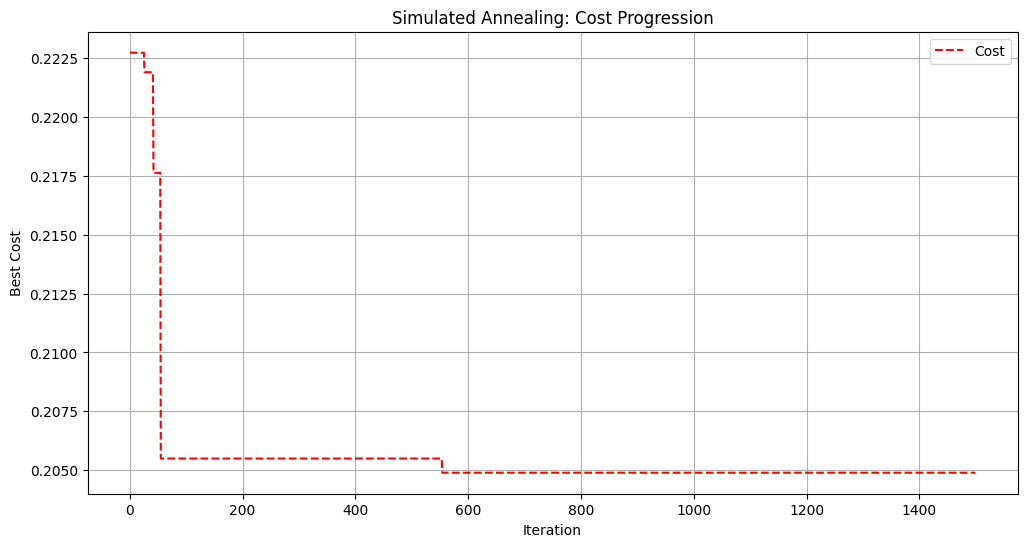

In [ ]:
# Initial parameters
#N = df_observed_data[['count_Exposed', 'count_Infectious', 'count_Recovered']].max().max()
N = 33235
I0 = train_data['count_Infectious'].iloc[0] # Initial infected from data
E0 = train_data['count_Exposed'].iloc[0] # Initial exposed cases
R0 = train_data['count_Recovered'].iloc[0] # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions: tuple = [S0, E0, I0, R0]

# Simulated Annealing parameters
temp = 1500  
cooling_rate = 0.99
max_iter = 1500  

observed_data = train_data[["count_Exposed", "count_Infectious", "count_Recovered"]].to_numpy()

time_points = np.arange(train_data.shape[0]) # odeint expects an array (vector) of integers.

# Run the Simulated Annealing algorithm
best_params, best_cost, cost_list, final_temp, best_mae, best_rmse = simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter, N)
o_beta, o_sigma, o_gamma = best_params

print(f"Final Temp = {final_temp} \nBest Cost = {best_cost:.3f} \n\nPrameters: \nbeta: {o_beta:.3f} \nsigma: {o_sigma:.3f} \ngamma:{o_gamma:.3f}\n")
print(f"Metrics: \nbest mae: {best_mae:.3f} \nbest rmse: {best_rmse:.3f}")

# Plot cost progression each compartment
plt.figure(figsize=(12, 6))
plt.plot(cost_list, 'r--', label='Cost')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Best Cost")
plt.title(f"Simulated Annealing: Cost Progression")
plt.grid(True)
plt.show()


# Plot for prediction

6 11 971
beta: 0.202 
r2: -0.18586369607663822 
mae: 8.239853876367507 
rmse: 18.053496511806074


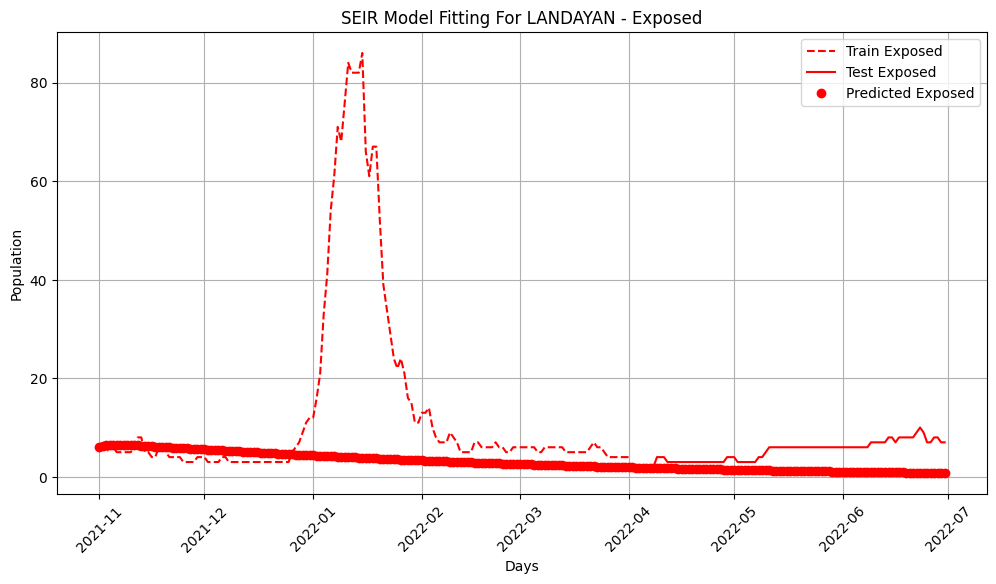

sigma: 0.253 
r2: -0.2675481197453662 
mae: 17.39860871172631 
rmse: 34.23835045640099


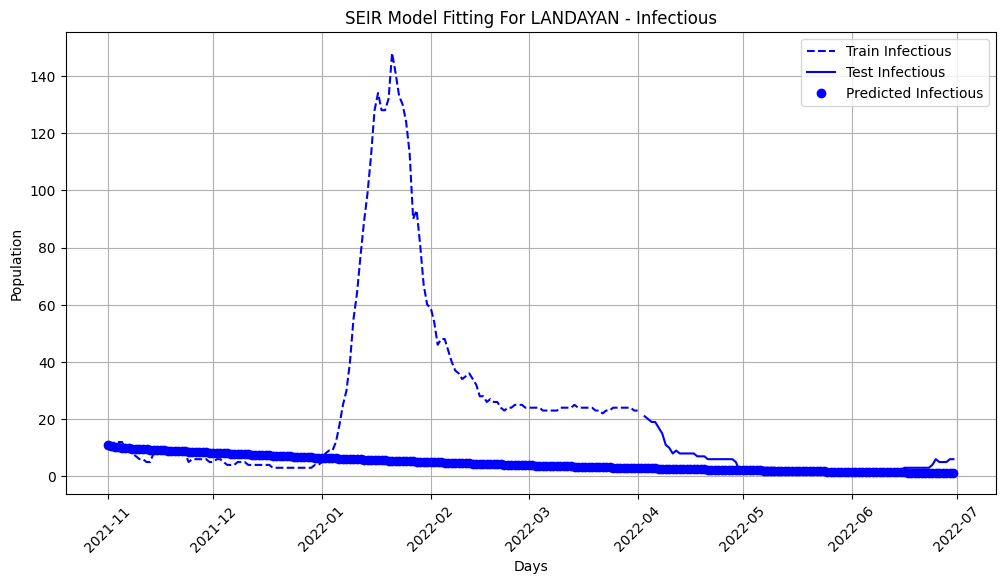

gamma: 0.178 
r2: 0.20527379952603442 
mae: 113.14436936168603 
rmse: 126.59854784010217


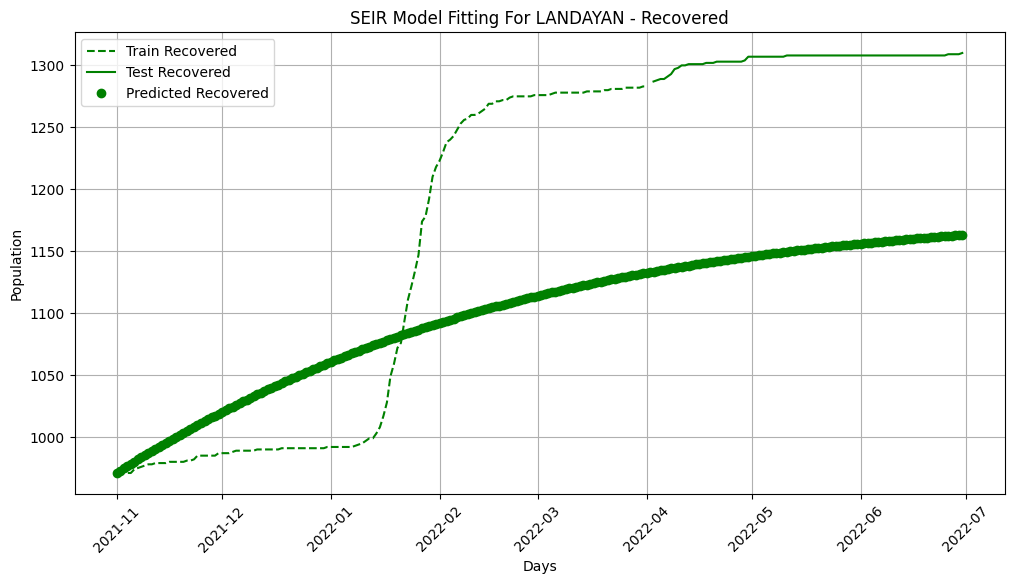

In [80]:
'''
Final Temp = 1.0100942081198105 
Best Cost = 0.205 

Prameters: 
beta: 0.389 
sigma: 1.000 
gamma:0.361

Metrics: 
best mae: 4.175 
best rmse: 8.528
'''

o_beta, o_sigma, o_gamma = 0.202, 0.253, 0.178 # from best params

observed_main = df_observed_data.copy()
observed_test = df_observed_data.copy() # maybe change to test data

E0 = observed_test['count_Exposed'].iloc[0] # Initial exposed cases
I0 = observed_test['count_Infectious'].iloc[0] # Initial infected from data
R0 = observed_test['count_Recovered'].iloc[0] # Initial recovered
S0 = N - E0 - I0 - R0  # Susceptible

print(E0, I0, R0)

initial_conditions: tuple = [S0, E0, I0, R0]

time_points = np.arange(observed_test.shape[0]) # odeint expects an array (vector) of integers.

# for plotting
plot_actual = pd.DataFrame({
    'date_train': train_data['date'],
    'date_test': test_data['date'],
    'train_exposed': train_data['count_Exposed'],
    'test_exposed': test_data['count_Exposed'],
    'train_infectious': train_data['count_Infectious'],
    'test_infectious': test_data['count_Infectious'],
    'train_recovered': train_data['count_Recovered'],
    'test_recovered': test_data['count_Recovered']
})

# simulate with the optimized paramaters
s, e, i, r = simulate_seir(o_beta, o_sigma, o_gamma, initial_conditions, time_points, N)

plot_prediction = pd.DataFrame({
    'date': observed_test['date'],
    'S': s,
    'E': e,
    'I': i,
    'R': r
})


# Exposed
r2_exposed = r2_score(observed_test['count_Exposed'], e)
mae_exposed = mean_absolute_error(observed_test['count_Exposed'], e)
rmse_exposed = np.sqrt(mean_squared_error(observed_test['count_Exposed'], e))
print(f"beta: {o_beta} \nr2: {r2_exposed} \nmae: {mae_exposed} \nrmse: {rmse_exposed}")
plt.figure(figsize=(12, 6))
#plt.plot(plot_prediction['date'], plot_prediction['S'], 'y--', label='Susceptible')
plt.plot(plot_actual['date_train'], plot_actual['train_exposed'], 'r--', label='Train Exposed')
plt.plot(plot_actual['date_test'], plot_actual['test_exposed'], 'r-', label='Test Exposed')
plt.plot(plot_prediction['date'], plot_prediction['E'], 'ro', label='Predicted Exposed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Exposed')
plt.grid(True)
plt.show()

# Infectious
r2_infectious = r2_score(observed_test['count_Infectious'], i)
mae_infectious = mean_absolute_error(observed_test['count_Infectious'], i)
rmse_infectious = np.sqrt(mean_squared_error(observed_test['count_Infectious'], i))
print(f"sigma: {o_sigma} \nr2: {r2_infectious} \nmae: {mae_infectious} \nrmse: {rmse_infectious}")
plt.figure(figsize=(12, 6))
#plt.plot(plot_prediction['date'], plot_prediction['S'], 'y--', label='Susceptible')
plt.plot(plot_actual['date_train'], plot_actual['train_infectious'], 'b--', label='Train Infectious')
plt.plot(plot_actual['date_test'], plot_actual['test_infectious'], 'b-', label='Test Infectious')
plt.plot(plot_prediction['date'], plot_prediction['I'], 'bo', label='Predicted Infectious')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Infectious')
plt.grid(True)
plt.show()

# Recovered
r2_recovered = r2_score(observed_test['count_Recovered'], r)
mae_recovered = mean_absolute_error(observed_test['count_Recovered'], r)
rmse_recovered = np.sqrt(mean_squared_error(observed_test['count_Recovered'], r))
print(f"gamma: {o_gamma} \nr2: {r2_recovered} \nmae: {mae_recovered} \nrmse: {rmse_recovered}")
plt.figure(figsize=(12, 6))
#plt.plot(plot_prediction['date'], plot_prediction['S'], 'y--', label='Susceptible')
plt.plot(plot_actual['date_train'], plot_actual['train_recovered'], 'g--', label='Train Recovered')
plt.plot(plot_actual['date_test'], plot_actual['test_recovered'], 'g-', label='Test Recovered')
plt.plot(plot_prediction['date'], plot_prediction['R'], 'go', label='Predicted Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Recovered')
plt.grid(True)
plt.show()

In [10]:
rec_max = df_observed_data[df_observed_data['count_Recovered']==df_observed_data['count_Recovered']].max()
print(rec_max)

rec_sum = main_observed['count_Recovered'].sum()
print(rec_sum)

date                2022-12-31 00:00:00
count_Exposed                        86
count_Infectious                    148
count_Recovered                    1480
dtype: object
1227791
